In [1]:
import numpy as np 
import scanpy as sc
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [50]:
chen_patient_order_by_MSI_intensity     = ['P18', 'P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']
chen_patient_order_by_MSI_intensity_P18 = ['P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']

chen_patient_order_by_MSI_intensity_AC  = ['P26', 'P20', 'P21', 'P04']
chen_patient_order_by_MSI_intensity_TC  = ['P19', 'P22', 'P23',]
chen_patient_order_by_MSI_intensity_SC  = ['P18', 'P17', 'P15']

joanito_patient_order_by_MSI_intensity  = ['CRC2817', 'SC035', 'CRC2783', 'SC044']

# XGBoost

## Load data

In [2]:
adata_epi_chen      = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.Epi.h5ad')
adata_epi_joanito   = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.ManualAnnot.Epi.h5ad')

### Joanito et al - No batch correction

In [12]:
adata_epi_joanito_tumor = adata_epi_joanito[adata_epi_joanito.obs['Manual_CellType_lvl_1']=='Tumor epithelial'].copy()
adata_epi_joanito_tumor = adata_epi_joanito_tumor.raw.to_adata()
adata_epi_joanito_tumor.shape

(7390, 29511)

In [14]:
sc.pp.filter_genes(adata_epi_joanito_tumor, min_cells=500)
adata_epi_joanito_tumor.shape

(7390, 12307)

In [15]:
sc.pp.normalize_total(adata_epi_joanito_tumor)
sc.pp.log1p(adata_epi_joanito_tumor)
sc.pp.scale(adata_epi_joanito_tumor, max_value=10)

In [54]:
minimum_loci = 10
adata_epi_joanito_tumor_oi = adata_epi_joanito_tumor[(adata_epi_joanito_tumor.obs['NumSTRLoci']>=minimum_loci) & 
                                                     (adata_epi_joanito_tumor.obs['PatientID'].isin(['CRC2817', 'SC035', 'CRC2783', 'SC044']))].copy()
adata_epi_joanito_tumor_oi.shape

(3454, 12307)

In [55]:
X = adata_epi_joanito_tumor_oi.X if isinstance(adata_epi_joanito_tumor_oi.X, np.ndarray) else adata_epi_joanito_tumor_oi.X.toarray()  # Ensure dense format
y = adata_epi_joanito_tumor_oi.obs['AvgSTRDiff'].values
X_hvg = adata_epi_joanito_tumor_oi.X if isinstance(adata_epi_joanito_tumor_oi.X, np.ndarray) else adata_epi_joanito_tumor_oi.X.toarray()

X_train, X_test, y_train, y_test = train_test_split(X_hvg, y, test_size=0.2, random_state=42)

In [56]:
model = XGBRegressor(
    objective='reg:squarederror',  # For regression tasks
    n_estimators=100,             # Number of boosting rounds
    learning_rate=0.1,            # Step size shrinkage
    max_depth=6,                  # Depth of each tree
    random_state=42               # For reproducibility
)

In [57]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [58]:
# Predict on test data
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 0.13316611384970486
R² Score: 0.7587782662881527


In [59]:
importance_threshold = np.mean(model.feature_importances_) + 3 * np.std(model.feature_importances_)
importance_threshold

In [62]:
important_genes = list()
for idx, importance in enumerate(model.feature_importances_):
    if importance >= importance_threshold:
        print(round(100*importance, 1), adata_epi_joanito_tumor_oi.var.index[idx])
        important_genes.append(adata_epi_joanito_tumor_oi.var.index[idx])

0.4 S100A6
0.7 RPL39L
0.4 LINC02432
1.8 LINC02163
12.9 LDHB
0.5 LYZ
0.5 SMOC1
0.5 CRIP1
4.2 PRSS21
2.7 PRAC1
0.5 KLK1


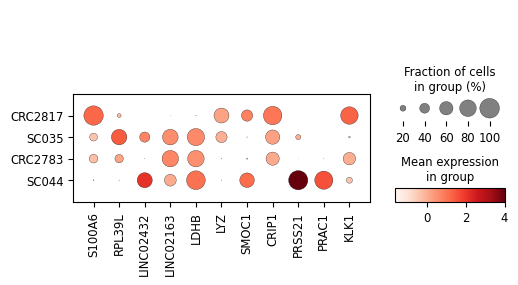

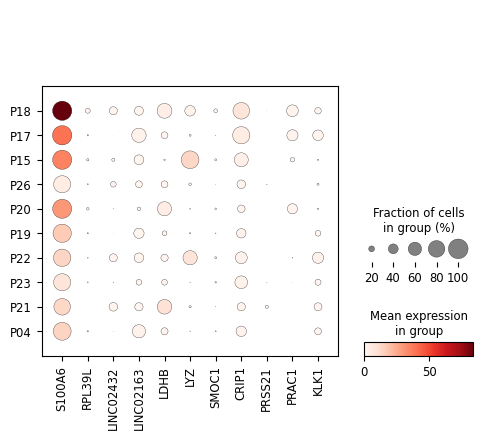

In [66]:
sc.pl.dotplot(adata_epi_joanito_tumor_oi, 
              var_names=important_genes, groupby='PatientID', 
              categories_order=joanito_patient_order_by_MSI_intensity)
sc.pl.dotplot(adata_epi_chen[adata_epi_chen.obs['Manual_CellType_lvl_1']=='Tumor epithelial'], 
              var_names=important_genes, groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity)

### Chen et al - All samples - No batch correction

In [176]:
adata_epi_chen_tumor = adata_epi_chen[adata_epi_chen.obs['Manual_CellType_lvl_1']=='Tumor epithelial'].copy()
adata_epi_chen_tumor = adata_epi_chen_tumor.raw.to_adata()
adata_epi_chen_tumor.shape

(13709, 28974)

In [177]:
sc.pp.filter_genes(adata_epi_chen_tumor, min_cells=500)
adata_epi_chen_tumor.shape

(13709, 11450)

In [178]:
sc.pp.normalize_total(adata_epi_chen_tumor)
sc.pp.log1p(adata_epi_chen_tumor)
sc.pp.scale(adata_epi_chen_tumor, max_value=10)

In [179]:
minimum_loci = 10
adata_epi_chen_tumor_oi = adata_epi_chen_tumor[(adata_epi_chen_tumor.obs['NumSTRLoci']>=minimum_loci) & 
                                               (adata_epi_chen_tumor.obs['PatientID'].isin(chen_patient_order_by_MSI_intensity))].copy()
adata_epi_chen_tumor_oi.shape

(13478, 11450)

In [180]:
X = adata_epi_chen_tumor_oi.X if isinstance(adata_epi_chen_tumor_oi.X, np.ndarray) else adata_epi_chen_tumor_oi.X.toarray()  # Ensure dense format
y = adata_epi_chen_tumor_oi.obs['AvgSTRDiff'].values
X_hvg = adata_epi_chen_tumor_oi.X if isinstance(adata_epi_chen_tumor_oi.X, np.ndarray) else adata_epi_chen_tumor_oi.X.toarray()

X_train, X_test, y_train, y_test = train_test_split(X_hvg, y, test_size=0.2, random_state=42)

In [181]:
model = XGBRegressor(
    objective='reg:squarederror',  # For regression tasks
    n_estimators=100,             # Number of boosting rounds
    learning_rate=0.1,            # Step size shrinkage
    max_depth=6,                  # Depth of each tree
    random_state=42               # For reproducibility
)

In [182]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [183]:
# Predict on test data
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 0.2197650300893328
R² Score: 0.5392242405632666


In [187]:
importance_threshold = np.mean(model.feature_importances_) + 3 * np.std(model.feature_importances_)
importance_threshold

0.0021231983628240414

In [188]:
important_genes = list()
for idx, importance in enumerate(model.feature_importances_):
    if importance >= importance_threshold:
        print(round(100*importance, 1), adata_epi_chen_tumor_oi.var.index[idx])
        important_genes.append(adata_epi_chen_tumor_oi.var.index[idx])

0.3 NFIA
1.0 L1TD1
1.2 REG4
0.3 S100A6
0.2 RPS27
0.6 REG1A
4.2 AC073365.1
0.2 MUC4
0.4 AC093817.2
1.0 ADAMTS6
0.4 RPS23
0.2 ADGRV1
0.6 RGMB
1.6 SEMA6A
0.4 CD74
0.3 CDHR2
0.3 DST
0.3 CD24
0.3 NPSR1
0.3 GNGT1
1.4 CPED1
1.2 PRUNE2
0.5 PRKG1
0.3 MUC5AC
0.2 H19
0.2 SYTL2
0.3 SLCO1B3
1.3 LINC02086
4.1 PRAC1
0.5 ABCC3
0.2 RPL36
1.0 RPS28
0.3 IGLV2-8
0.2 XACT
0.3 LINC01285
0.3 MT-ND3


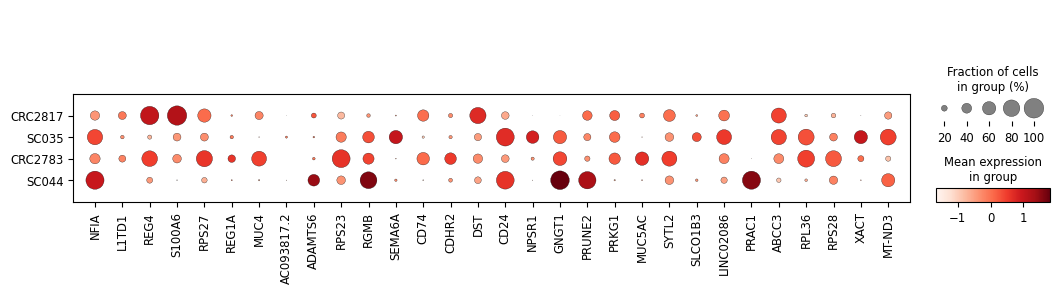

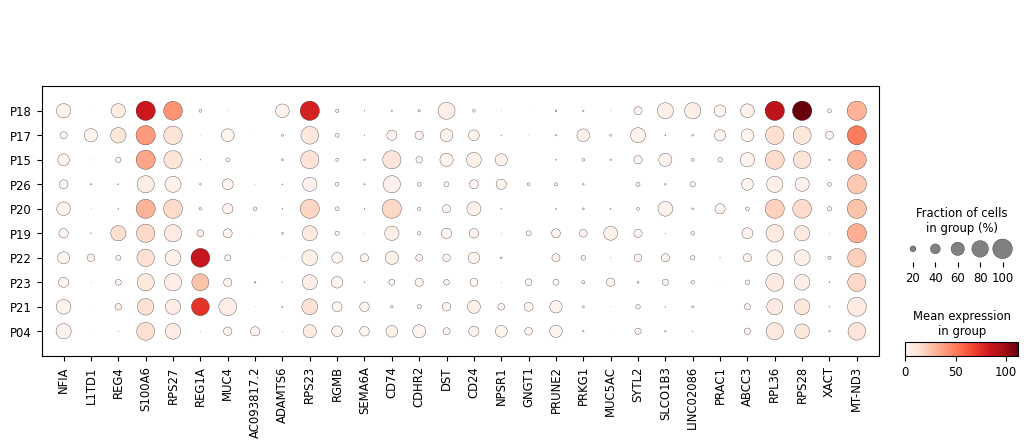

In [189]:
sc.pl.dotplot(adata_epi_joanito_tumor_oi, 
              var_names=[g for g in important_genes if g in adata_epi_joanito_tumor_oi.var.index], groupby='PatientID', 
              categories_order=joanito_patient_order_by_MSI_intensity)
sc.pl.dotplot(adata_epi_chen[adata_epi_chen.obs['Manual_CellType_lvl_1']=='Tumor epithelial'], 
              var_names=[g for g in important_genes if g in adata_epi_joanito_tumor_oi.var.index], groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity)

### Chen et al - Excluding P18 - No batch correction

In [84]:
adata_epi_chen_tumor = adata_epi_chen[(adata_epi_chen.obs['Manual_CellType_lvl_1']=='Tumor epithelial') & 
                                      (adata_epi_chen.obs['PatientID']!='P18')].copy()
adata_epi_chen_tumor = adata_epi_chen_tumor.raw.to_adata()
adata_epi_chen_tumor.shape

(11695, 28974)

In [85]:
sc.pp.filter_genes(adata_epi_chen_tumor, min_cells=500)
adata_epi_chen_tumor.shape

(11695, 10687)

In [86]:
sc.pp.normalize_total(adata_epi_chen_tumor)
sc.pp.log1p(adata_epi_chen_tumor)
sc.pp.scale(adata_epi_chen_tumor, max_value=10)

In [87]:
minimum_loci = 10
adata_epi_chen_tumor_oi = adata_epi_chen_tumor[(adata_epi_chen_tumor.obs['NumSTRLoci']>=minimum_loci) & 
                                               (adata_epi_chen_tumor.obs['PatientID'].isin(chen_patient_order_by_MSI_intensity))].copy()
adata_epi_chen_tumor_oi.shape

(11471, 10687)

In [88]:
X = adata_epi_chen_tumor_oi.X if isinstance(adata_epi_chen_tumor_oi.X, np.ndarray) else adata_epi_chen_tumor_oi.X.toarray()  # Ensure dense format
y = adata_epi_chen_tumor_oi.obs['AvgSTRDiff'].values
X_hvg = adata_epi_chen_tumor_oi.X if isinstance(adata_epi_chen_tumor_oi.X, np.ndarray) else adata_epi_chen_tumor_oi.X.toarray()

X_train, X_test, y_train, y_test = train_test_split(X_hvg, y, test_size=0.2, random_state=42)

In [89]:
model = XGBRegressor(
    objective='reg:squarederror',  # For regression tasks
    n_estimators=100,             # Number of boosting rounds
    learning_rate=0.1,            # Step size shrinkage
    max_depth=6,                  # Depth of each tree
    random_state=42               # For reproducibility
)

In [90]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [91]:
# Predict on test data
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 0.23875227949934358
R² Score: 0.4035305735707676


In [92]:
importance_threshold = np.mean(model.feature_importances_) + 3 * np.std(model.feature_importances_)
importance_threshold

0.0016147995775099844

In [93]:
important_genes = list()
for idx, importance in enumerate(model.feature_importances_):
    if importance >= importance_threshold:
        print(round(100*importance, 1), adata_epi_chen_tumor_oi.var.index[idx])
        important_genes.append(adata_epi_chen_tumor_oi.var.index[idx])

4.0 L1TD1
0.7 REG4
0.4 LAMC2
0.5 REG1A
0.5 REG3A
0.2 MUC4
0.2 JCHAIN
0.3 AC093817.2
0.2 ADGRV1
0.4 RGMB
0.9 SEMA6A
0.2 SPINK1
0.4 CD74
0.4 CDHR2
0.3 HLA-C
0.2 AC068587.4
0.7 PRUNE2
0.6 PRKG1
0.5 LRMDA
0.2 CDHR1
0.4 MUC6
0.5 H19
0.3 SYTL2
0.2 OLFM4
0.3 NFKBIA
0.2 CKB
0.3 LINC02691
0.2 PHGR1
0.4 TPM1
0.2 RPS27L
0.2 ANP32A
0.2 SLCO3A1
0.4 NPW
0.2 CYBA
1.1 PRAC1
0.2 WDR18
0.2 ZNF506
0.4 TFF3
0.2 IGLV1-40
0.7 IGLV2-14
0.2 XACT
0.2 LINC01285
0.2 ARHGAP4
0.8 RPS4Y1
0.7 MT-ND3


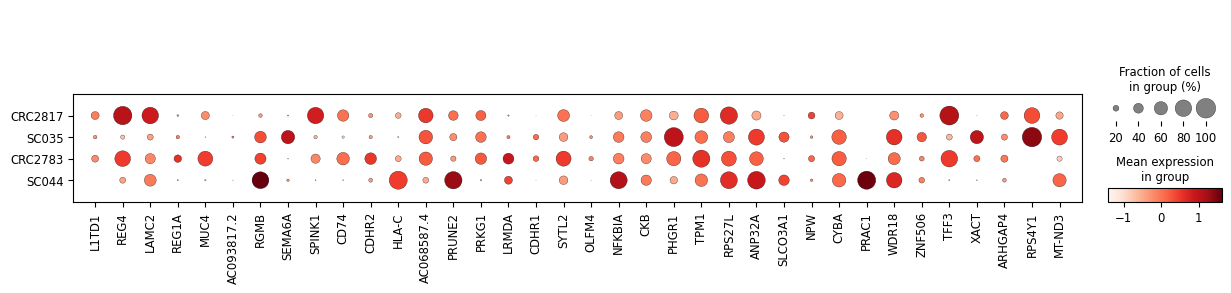

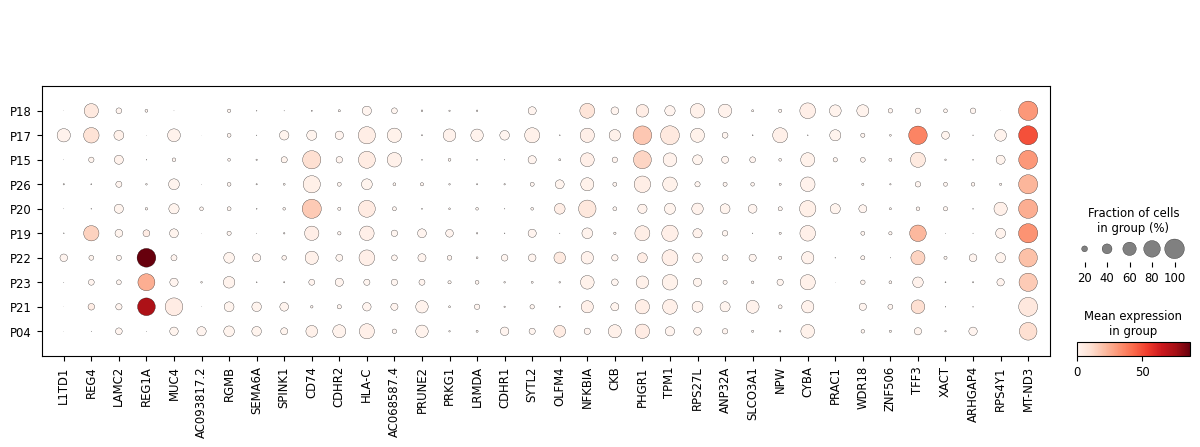

In [94]:
sc.pl.dotplot(adata_epi_joanito_tumor_oi, 
              var_names=[g for g in important_genes if g in adata_epi_joanito_tumor_oi.var.index], groupby='PatientID', 
              categories_order=joanito_patient_order_by_MSI_intensity)
sc.pl.dotplot(adata_epi_chen[adata_epi_chen.obs['Manual_CellType_lvl_1']=='Tumor epithelial'], 
              var_names=[g for g in important_genes if g in adata_epi_joanito_tumor_oi.var.index], groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity)

### Chen et al - AC only - No batch correction

In [110]:
adata_epi_chen_tumor = adata_epi_chen[(adata_epi_chen.obs['Manual_CellType_lvl_1']=='Tumor epithelial') & 
                                      (adata_epi_chen.obs['TumorLocation']=='Ascending colon')].copy()
adata_epi_chen_tumor = adata_epi_chen_tumor.raw.to_adata()
adata_epi_chen_tumor.shape

(5131, 28974)

In [111]:
sc.pp.filter_genes(adata_epi_chen_tumor, min_cells=500)
adata_epi_chen_tumor.shape

(5131, 7369)

In [112]:
sc.pp.normalize_total(adata_epi_chen_tumor)
sc.pp.log1p(adata_epi_chen_tumor)
sc.pp.scale(adata_epi_chen_tumor, max_value=10)

In [161]:
minimum_loci = 10
adata_epi_chen_tumor_oi = adata_epi_chen_tumor[(adata_epi_chen_tumor.obs['NumSTRLoci']>=minimum_loci) & 
                                               (adata_epi_chen_tumor.obs['PatientID'].isin(chen_patient_order_by_MSI_intensity))].copy()
adata_epi_chen_tumor_oi.shape

(11471, 4000)

In [114]:
X = adata_epi_chen_tumor_oi.X if isinstance(adata_epi_chen_tumor_oi.X, np.ndarray) else adata_epi_chen_tumor_oi.X.toarray()  # Ensure dense format
y = adata_epi_chen_tumor_oi.obs['AvgSTRDiff'].values
X_hvg = adata_epi_chen_tumor_oi.X if isinstance(adata_epi_chen_tumor_oi.X, np.ndarray) else adata_epi_chen_tumor_oi.X.toarray()

X_train, X_test, y_train, y_test = train_test_split(X_hvg, y, test_size=0.2, random_state=42)

In [115]:
model = XGBRegressor(
    objective='reg:squarederror',  # For regression tasks
    n_estimators=20,             # Number of boosting rounds
    learning_rate=0.1,            # Step size shrinkage
    max_depth=6,                  # Depth of each tree
    random_state=42               # For reproducibility
)

In [116]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [117]:
# Predict on test data
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 0.2725503071698662
R² Score: 0.33403665501981317


In [118]:
importance_threshold = np.mean(model.feature_importances_) + 3 * np.std(model.feature_importances_)
importance_threshold

0.003044113313080743

In [119]:
important_genes = list()
for idx, importance in enumerate(model.feature_importances_):
    if importance >= importance_threshold:
        print(round(100*importance, 1), adata_epi_chen_tumor_oi.var.index[idx])
        important_genes.append(adata_epi_chen_tumor_oi.var.index[idx])

0.3 RSBN1
0.3 MUC1
0.5 TMEM183A
0.3 LINC02474
0.3 ASXL2
0.4 REG1A
0.5 IGKC
0.3 IGKV4-1
0.6 IGKV1-5
2.4 IGKV3-20
0.4 AC105402.3
0.4 SHQ1
0.8 JCHAIN
1.2 CXCL3
0.5 AC093817.2
0.3 LINC01612
0.5 PPWD1
0.3 PAM
0.4 LINC02163
0.4 SEMA6A
0.5 MARCH3
0.6 SIL1
0.3 ANKHD1
2.7 CD74
0.8 CDHR2
0.5 SQSTM1
0.5 RNF5
0.6 HLA-DRB5
0.3 MAPK14
0.7 NPSR1
0.4 SHB
0.3 ANXA11
0.7 ADIRF
0.3 NDUFB8
0.4 ADD3
0.3 SEC23IP
0.4 PDE3B
2.0 NEAT1
0.3 SLC29A2
0.3 RPL6
0.3 RUBCNL
0.3 LMO7
0.4 ARGLU1
0.3 NFKBIA
0.4 ERH
0.9 CKB
0.4 CDH13
0.4 SLC7A5
1.2 KRT17
0.5 SRSF1
0.3 CDC42EP4
0.4 AFMID
0.3 RNF213
0.4 CD3EAP
0.5 CST3
0.3 RNF114
0.4 IGLV1-44
0.6 IGLV1-40
5.0 IGLV2-14
0.4 CABIN1
0.4 ASMTL
0.6 DDX3X
0.5 ARHGAP4
1.7 RPS4Y1


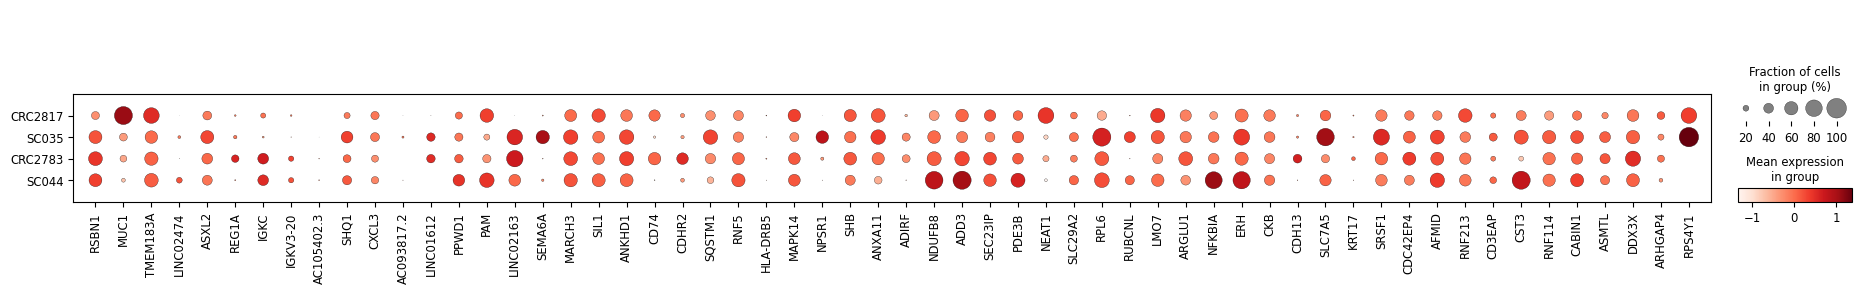

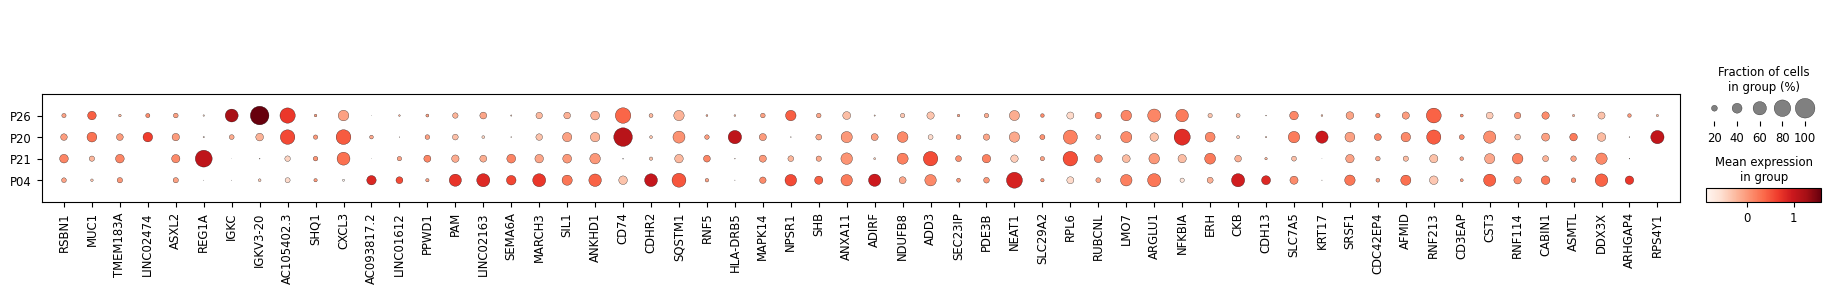

In [120]:
sc.pl.dotplot(adata_epi_joanito_tumor_oi, 
              var_names=[g for g in important_genes if g in adata_epi_joanito_tumor_oi.var.index], groupby='PatientID', 
              categories_order=joanito_patient_order_by_MSI_intensity)
sc.pl.dotplot(adata_epi_chen_tumor_oi[adata_epi_chen_tumor_oi.obs['Manual_CellType_lvl_1']=='Tumor epithelial'], 
              var_names=[g for g in important_genes if g in adata_epi_joanito_tumor_oi.var.index], groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_AC)

### Chen et al - Excluding P18 - HVG - No batch correction

In [162]:
adata_epi_chen_tumor = adata_epi_chen[(adata_epi_chen.obs['Manual_CellType_lvl_1']=='Tumor epithelial') & 
                                      (adata_epi_chen.obs['PatientID']!='P18')].copy()
adata_epi_chen_tumor = adata_epi_chen_tumor.raw.to_adata()
adata_epi_chen_tumor.shape

(11695, 28974)

In [163]:
sc.pp.filter_genes(adata_epi_chen_tumor, min_cells=500)
adata_epi_chen_tumor.shape

(11695, 10687)

In [164]:
sc.pp.normalize_total(adata_epi_chen_tumor)
sc.pp.log1p(adata_epi_chen_tumor)
sc.pp.highly_variable_genes(adata_epi_chen_tumor, n_top_genes=4000, batch_key="PatientID")
adata_epi_chen_tumor = adata_epi_chen_tumor[:, adata_epi_chen_tumor.var.highly_variable]
sc.pp.scale(adata_epi_chen_tumor, max_value=10)

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [165]:
minimum_loci = 30
adata_epi_chen_tumor_oi = adata_epi_chen_tumor[(adata_epi_chen_tumor.obs['NumSTRLoci']>=minimum_loci) & 
                                               (adata_epi_chen_tumor.obs['PatientID'].isin(chen_patient_order_by_MSI_intensity))].copy()
adata_epi_chen_tumor_oi.shape

(10042, 4000)

In [166]:
X = adata_epi_chen_tumor_oi.X if isinstance(adata_epi_chen_tumor_oi.X, np.ndarray) else adata_epi_chen_tumor_oi.X.toarray()  # Ensure dense format
y = adata_epi_chen_tumor_oi.obs['AvgSTRDiff'].values
X_hvg = adata_epi_chen_tumor_oi.X if isinstance(adata_epi_chen_tumor_oi.X, np.ndarray) else adata_epi_chen_tumor_oi.X.toarray()

X_train, X_test, y_train, y_test = train_test_split(X_hvg, y, test_size=0.2, random_state=42)

In [167]:
model = XGBRegressor(
    objective='reg:squarederror',  # For regression tasks
    n_estimators=100,             # Number of boosting rounds
    learning_rate=0.1,            # Step size shrinkage
    max_depth=6,                  # Depth of each tree
    random_state=42               # For reproducibility
)

In [168]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [169]:
# Predict on test data
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 0.18816805206960605
R² Score: 0.47072805991596345


In [170]:
importance_threshold = np.mean(model.feature_importances_) + 3 * np.std(model.feature_importances_)
importance_threshold

0.002323062071809545

In [171]:
important_genes = list()
for idx, importance in enumerate(model.feature_importances_):
    if importance >= importance_threshold:
        print(round(100*importance, 1), adata_epi_chen_tumor_oi.var.index[idx])
        important_genes.append(adata_epi_chen_tumor_oi.var.index[idx])

0.3 CLCA1
1.0 REG4
0.3 NVL
0.3 AC012494.1
1.2 REG1A
0.3 THORLNC
0.3 ANO7
1.0 AC093817.2
0.2 LINC01612
0.2 ZDHHC11B
0.3 RGMB
0.6 SEMA6A
0.6 CD74
0.2 HLA-DRA
0.3 TNFRSF10C
1.3 PRUNE2
0.3 PFKP
1.9 PRKG1
0.5 LRMDA
0.3 ADIRF
0.6 MUC6
0.3 MUC5AC
0.5 MDK
0.5 SYTL2
0.3 CCND2
0.2 CKB
0.5 LINC02691
0.2 IGHV3-7
0.4 PHGR1
0.8 NPW
0.3 SHISA6
0.3 WFDC2
1.3 TFF3
0.3 XACT
0.9 MT-ND3


In [174]:
'S100A6' in adata_epi_chen_tumor_oi.var.index

True

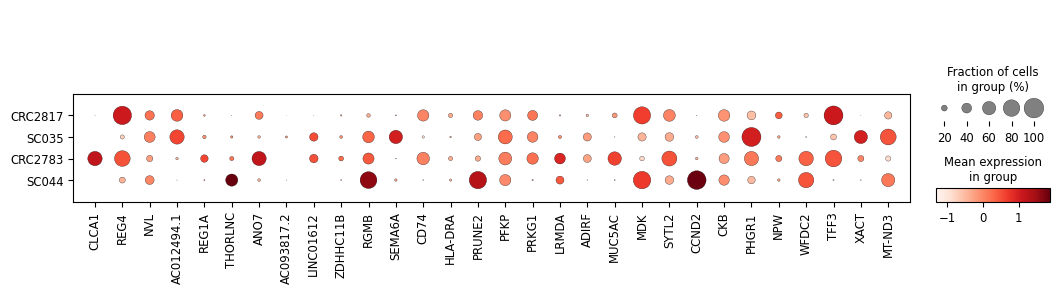

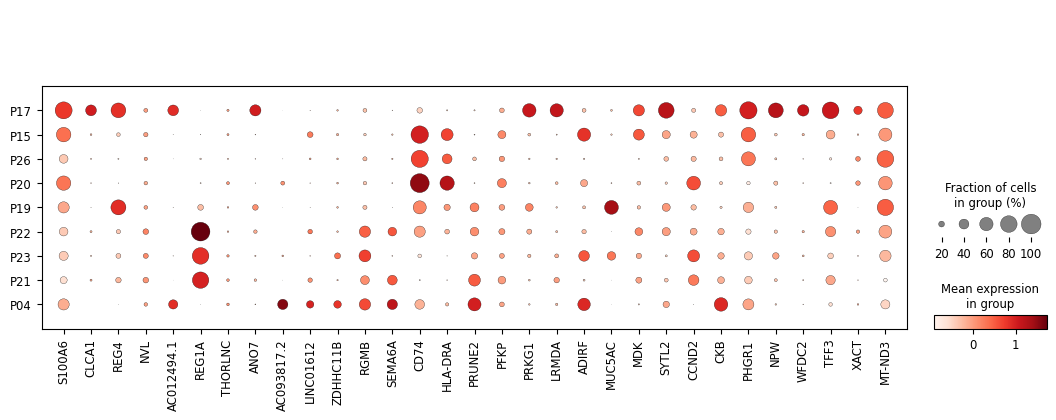

In [175]:
sc.pl.dotplot(adata_epi_joanito_tumor_oi, 
              var_names=[g for g in important_genes if g in adata_epi_joanito_tumor_oi.var.index], groupby='PatientID', 
              categories_order=joanito_patient_order_by_MSI_intensity)
sc.pl.dotplot(adata_epi_chen_tumor_oi, 
              var_names=['S100A6'] + [g for g in important_genes if g in adata_epi_joanito_tumor_oi.var.index], groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_P18)